In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from pathlib import Path
import glob
import re

from plaid.evaluation import calculate_ca_rmsd, run_tmalign, rmspd_from_pdb_paths
from plaid.utils import read_sequences_from_fasta, calc_sequence_recovery, extract_avg_b_factor_per_residue
from plaid.evaluation import  run_tmalign

import os
import multiprocessing as mp
from functools import partial

import numpy as np
import typing as T
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import PDB

import re
import wandb


In [34]:
sample_dir = "/data/lux70/data/pfam/val_stats/"
sample_dir = Path(sample_dir)

def filename_to_suffix_number(path):
    x = str(path).split("/")[-1]
    return int(re.findall(r"\d+", x)[-1])

def sort_by_suffix(lst):
    import re
    sorted_list = sorted(lst, key=lambda path: filename_to_suffix_number(path))
    return sorted_list

In [35]:
sequences_dict = read_sequences_from_fasta(sample_dir /  "generated/sequences.fasta")

gen_pdbs = glob.glob(str(sample_dir /  "generated/structures/*pdb"))
gen_pdbs = sort_by_suffix(gen_pdbs)

inverse_gen_pdbs = glob.glob(str(sample_dir / "inverse_generated/structures/*pdb"))
inverse_gen_pdbs = sort_by_suffix(inverse_gen_pdbs)
 
# phantom_gen_pdbs = glob.glob(str(sample_dir / "phantom_generated/structures/*pdb"))
# phantom_gen_pdbs = sort_by_suffix(phantom_gen_pdbs)

In [17]:
print(gen_pdbs[-3:])
print(inverse_gen_pdbs[-3:])
# print(phantom_gen_pdbs[-3:])

['/data/lux70/data/pfam/val_stats/generated/structures/pfam6397.pdb', '/data/lux70/data/pfam/val_stats/generated/structures/pfam6398.pdb', '/data/lux70/data/pfam/val_stats/generated/structures/pfam6399.pdb']
['/data/lux70/data/pfam/val_stats/inverse_generated/structures/pfam6397.pdb', '/data/lux70/data/pfam/val_stats/inverse_generated/structures/pfam6398.pdb', '/data/lux70/data/pfam/val_stats/inverse_generated/structures/pfam6399.pdb']


In [18]:
sequences = [sequences_dict[p] for p in gen_pdbs]
df = pd.DataFrame({"pdb_path": gen_pdbs, "sequence": sequences})
df['length'] = df.sequence.str.len().values
df['inverse_gen_pdb'] = inverse_gen_pdbs

<Axes: >

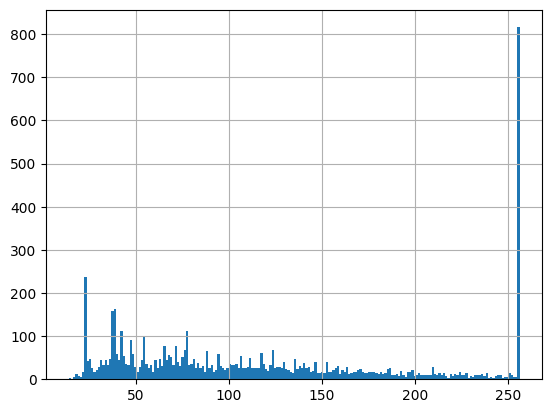

In [37]:
df['length'].hist(bins=200)

# Consistency, Perplexity, and pLDDT

In [25]:
def process_row(row):
    row['cctm'] = run_tmalign(row['pdb_path'], row['inverse_gen_pdb'])
    # row['ccrmspd'] = rmspd_from_pdb_paths(row['pdb_path'], row['inverse_gen_pdb']).item()
    row['plddt'] = np.mean(extract_avg_b_factor_per_residue(row['pdb_path']))
    return row

In [30]:
import pandas as pd
import multiprocessing as mp

# Function to apply in parallel
def parallel_apply(df, func):
    num_processes = min(mp.cpu_count(), df.shape[0])
    with mp.Pool(num_processes) as pool:
        results = pool.map(func, df)
    return results